In [12]:
import pathlib

import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm

import arviz as az
from aesara_theano_fallback import tensor as tt
import pymc3 as pm
import pymc3_ext as pmx

from hq.config import Config

In [2]:
allstar_path = pathlib.Path('~/data/APOGEE_DR17/allStar-dr17-synspec.fits')
allstar_path = allstar_path.expanduser().resolve()
assert allstar_path.exists()

In [3]:
hq_run_path = pathlib.Path('~/projects/apogee-dr17-binaries/')
hq_run_path = hq_run_path.expanduser().resolve()

hq_config_path = hq_run_path / 'hq-config/config.yml'
hq_cache_path = hq_run_path / 'cache/hq'
assert hq_config_path.exists()

In [4]:
allstar = at.QTable.read(allstar_path)

In [5]:
c = Config(hq_config_path)

In [6]:
metadata = at.QTable.read(hq_cache_path / 'metadata.fits')
metadata = at.join(metadata, allstar, keys='APOGEE_ID')
metadata = at.unique(metadata, keys='APOGEE_ID')
len(metadata)

358350

In [7]:
llr_const = metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood']

In [8]:
binaries_mask = (
    (llr_const > 5) & 
    (metadata['max_unmarginalized_ln_likelihood'] > -6)
)
binaries_mask.sum()

58743

In [17]:
logg_bins = np.arange(-0.25, 5.5, 0.05)
logg_binc = 0.5 * (logg_bins[:-1] + logg_bins[1:])

mh_mask = metadata['M_H'] > -1.
_mask = binaries_mask & mh_mask
    
H_bin, _ = np.histogram(metadata['LOGG'][binaries_mask & mh_mask], 
                        bins=logg_bins)
H_all, _ = np.histogram(metadata['LOGG'][mh_mask], 
                        bins=logg_bins)

ratio = (np.random.poisson(H_bin, size=(1_000, len(H_bin))) / 
         np.random.poisson(H_all, size=(1_000, len(H_all))))

data_x = logg_binc
data_y = np.mean(ratio, axis=0)
data_yerr = np.std(ratio, axis=0)

sort_idx = np.argsort(data_x)
data_x = data_x[sort_idx]
data_y = data_y[sort_idx]
data_yerr = data_yerr[sort_idx]

good_idx = np.isfinite(data_y)
data_x = data_x[good_idx]
data_y = data_y[good_idx]
data_yerr = data_yerr[good_idx]

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0, 0.5, 'obs. binary fraction')

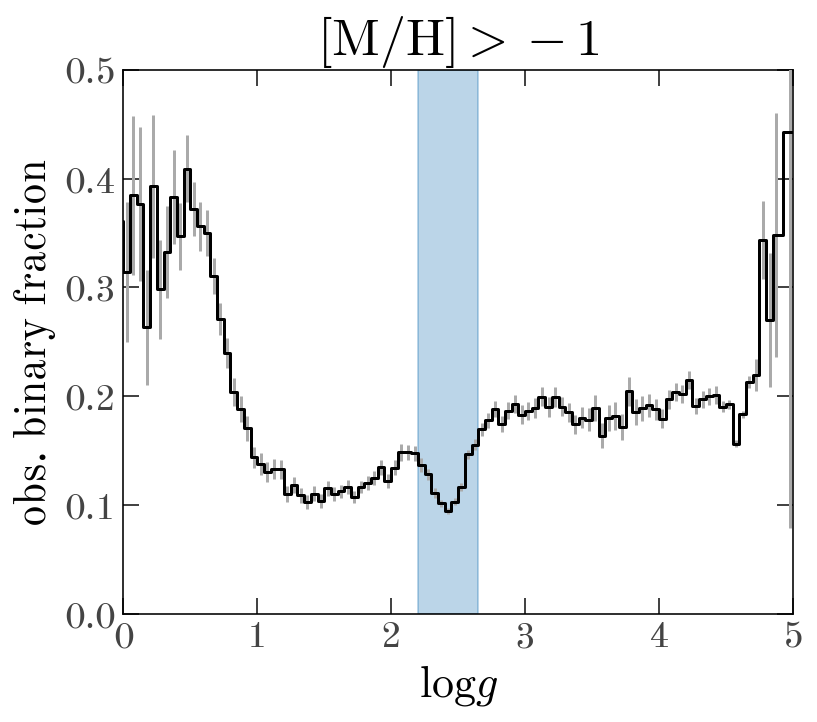

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(data_x,
        data_y,
        marker='', drawstyle='steps-mid', zorder=10)

ax.errorbar(data_x,
            data_y,
            data_yerr,
            ecolor='#aaaaaa', ls='none', marker='', zorder=5)

ax.set_title(r'$[{\rm M}/{\rm H}] > -1$')
ax.set_xlim(0., 4.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel(r'$\log g$')

ax.set_xticks(np.arange(0, 5+1, 1))

ax.axvspan(2.2, 2.65, color='tab:blue', alpha=0.3)

ax.set_ylabel('obs. binary fraction')

In [54]:
fit_idx = (
    (data_x > 1.25) &
    np.logical_not((data_x > 2.2) & (data_x < 2.65)) &
    (data_x < 4.5)
)
fit_x = data_x[fit_idx]
fit_y = data_y[fit_idx]
fit_yerr = data_yerr[fit_idx]

In [58]:
with pm.Model() as model:
    break_x = pm.Uniform('break_x', 2.5, 4)
    const_y = pm.Uniform('const_y', 0.1, 0.3)
    slope = pm.Uniform('slope', 1e-4, 1)
    
    model_y = tt.where(fit_x < break_x, 
                       slope * (fit_x - break_x) + const_y, 
                       const_y)
    lnlike = pm.Normal('lnlike', mu=model_y, sd=fit_yerr, observed=fit_y)
    
    res = pmx.optimize(start={
        'break_x': 2.8,
        'const_y': 0.18,
        'slope': 0.02
    })
    
    samples = pmx.sample(start=res, return_inferencedata=True)

optimizing logp for variables: [slope, const_y, break_x]


message: Optimization terminated successfully.
logp: -174.06779539112435 -> 177.40914320500528


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, const_y, break_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [62]:
for var in samples.posterior.data_vars:
    
    print(var)

break_x
const_y
slope


In [76]:
def get_model_y(x, res, subN=None, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
        
    if isinstance(res, dict):
        model_y = np.where(x < res['break_x'],
                           res['slope'] * (x - res['break_x']) + res['const_y'],
                           res['const_y'])
        return model_y
    
    elif isinstance(res, az.InferenceData):
        size = res.posterior.draw.size * res.posterior.chain.size
        samples = {k: res.posterior.get(k).values.ravel() 
                   for k in res.posterior.data_vars}
        
        if subN is not None:
            idx = rng.choice(size, size=subN, replace=False)
        else:
            idx = np.arange(size)
        
        if len(idx) > 1000:
            raise NotImplementedError()
            
        all_model_y = []
        for i in idx:
            model_y = get_model_y(x, {k: samples[k][i] for k in samples.keys()})
            all_model_y.append(model_y)
        
        return np.array(all_model_y)

In [106]:
min_idx = np.where((data_x > 2) & (data_x < 3))[0]
min_idx = min_idx[np.argmin(data_y[min_idx])]
print(data_x[min_idx])
data_y[min_idx], data_yerr[min_idx]

2.4249999999999994


(0.09424659828284744, 0.0025834120731101536)

In [105]:
tmp = get_model_y(data_x[min_idx], samples, subN=512)
pred_min_y = np.mean(tmp)
pred_min_yerr = np.std(tmp)
pred_min_y, pred_min_yerr

(0.15811497604128769, 0.0018235994088057503)

Text(0, 0.5, 'obs. binary fraction')

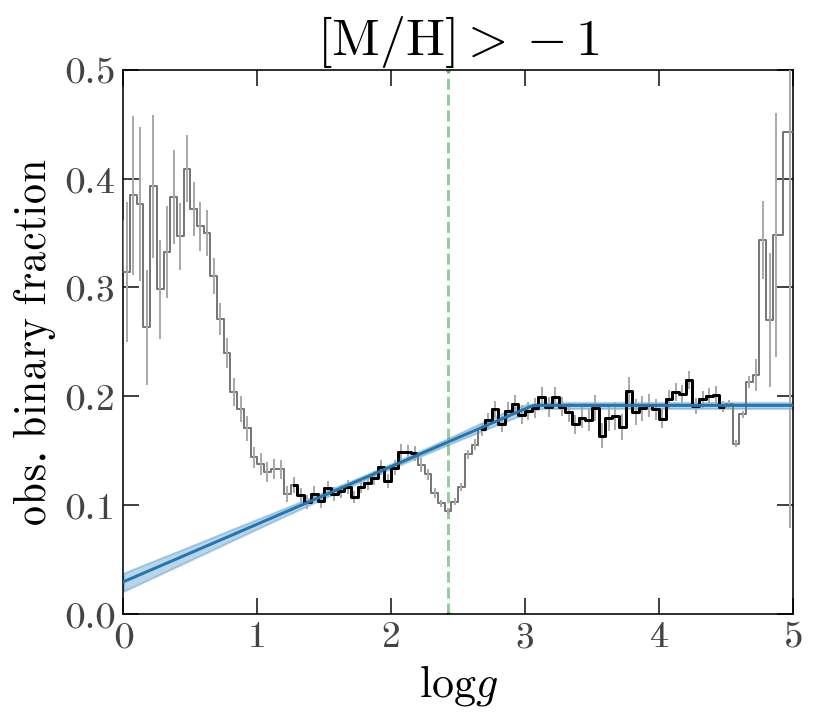

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(data_x,
        data_y,
        marker='', drawstyle='steps-mid', zorder=10,
        color='#777777', linewidth=1)

_idx = np.concatenate(([0], np.where(np.diff(fit_x) > 0.1)[0]+1, [len(fit_x)]))
for i1, i2 in zip(_idx[:-1], _idx[1:]):
    ax.plot(fit_x[i1:i2],
            fit_y[i1:i2],
            marker='', drawstyle='steps-mid', color='k', zorder=100)
    
ax.errorbar(data_x,
            data_y,
            data_yerr,
            ecolor='#aaaaaa', ls='none', marker='', zorder=100, elinewidth=1)

grid_x = np.linspace(0, 5, 128)
plt.plot(grid_x, get_model_y(grid_x, res), 
         marker='', color='tab:blue', zorder=200, ls='-')

pcl1, pcl2 = np.percentile(get_model_y(grid_x, samples, subN=512),
                           q=[5, 95], axis=0)
plt.fill_between(grid_x, pcl1, pcl2, color='tab:blue', alpha=0.3)
# plt.plot(grid_x, get_model_y(grid_x, samples, subN=512).T, 
#          marker='', color='tab:blue', alpha=0.1)

ax.set_title(r'$[{\rm M}/{\rm H}] > -1$')
ax.set_xlim(0., 4.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel(r'$\log g$')

ax.set_xticks(np.arange(0, 5+1, 1))

ax.axvline(data_x[min_idx], color='tab:green', linestyle='--', alpha=0.5)

ax.set_ylabel('obs. binary fraction')

## Fit in bins of metallicity?

In [1]:
mh_bin_centers = np.linspace(-1.8, 0.5, 8)
d_mh = mh_bin_centers[1] - mh_bin_centers[0]

fig, axes = plt.subplots(2, 4, 
                         figsize=(4 * 5, 2 * 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i, mh in enumerate(mh_bin_centers):
    mh_mask = np.abs(metadata['M_H'] - mh) < d_mh
    
    if (binaries_mask & mh_mask).sum() < 10_000:
        logg_bins = np.arange(-0.25, 5.5, 0.1)
    else:
        logg_bins = np.arange(-0.25, 5.5, 0.05)
    
    sub = metadata[mh_mask]
    H_good, _ = np.histogram(metadata['LOGG'][binaries_mask & mh_mask], 
                             bins=logg_bins)
    H_all, _ = np.histogram(metadata['LOGG'][mh_mask], 
                            bins=logg_bins)
    
    ratio = (np.random.poisson(H_good, size=(10_000, len(H_good))) / 
             np.random.poisson(H_all, size=(10_000, len(H_all))))
    
    ax = axes.flat[i]
    
    logg_binc = 0.5 * (logg_bins[:-1] + logg_bins[1:])
    ax.plot(logg_binc,
            np.mean(ratio, axis=0),
            marker='', drawstyle='steps-mid', zorder=10)
    ax.errorbar(logg_binc,
                np.mean(ratio, axis=0),
                np.std(ratio, axis=0),
                ecolor='#aaaaaa', ls='none', marker='', zorder=5)
    
    ax.set_title(r'$[{\rm M}/{\rm H}] = ' + f'{mh:.1f}$')
    ax.set_xlim(0., 4.5)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel(r'$\log g$')
    
    ax.axhline(0.2, color='tab:blue', alpha=0.5)
    ax.axvline(2.4, color='tab:green', alpha=0.5)

ax.set_xticks(np.arange(0, 5+1, 1))

for ax in axes[:, 0]:
    ax.set_ylabel('obs. binary fraction')

NameError: name 'np' is not defined